$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
\newcommand{In}[2]{ #1 \perp\!\!\!\perp #2}
\newcommand{Cin}[3]{ #1 \perp\!\!\!\perp #2 \, | \, #3}
\newcommand{do}[1]{\mathrm{do}\left( #1 \right)}
\newcommand{E}[1]{\mathrm{E}\left[ #1 \right]}
\newcommand{Ec}[2]{\mathrm{E}\left[ #1 \mid #2 \right]}
$$

In a [previous post](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/) I looked at how we can describe causal systems mathematically using the framework of causal graphical model. These models give us the ability to be precise about how we can phrase and answer causal questions of the form:

> "What effect does changing $X$ have on $Y$?"

These causal graphical model show us exactly why causality is difficult: if there exist ["backdoor paths" - or confounding variables](https://en.wikipedia.org/wiki/Confounding), common causes for both $X$ and $Y$, then it is possible that any observed correlation between $X$ and $Y$ is due to these confounding paths, and not a direct causal relationship between $X$ and $Y$.

In situations where we observe the confounding variables in a causal graphical model we can overcome this limitation by "adjusting" for the backdoor path (sometimes called "covariate adjustment", "backdoor adjustment, "controlling for variables"). My [first post](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/) contained a number of techniques for doing this. 

This leaves the question: if we do not observe enough variables to adjust for a backdoor, can we still make causal inferences? 

In some situations the answer to this question is yes. We will be examining one of these situations in this post. As in my previous post I will be using the [causalgraphicalmodels](https://github.com/ijmbarr/causalgraphicalmodels) python package for my examples.

Before we begin, we need to introduce some slightly new notation:

# Unobserved Variables

When we describe our system as a causal graphical model, the effect of unmeasured we would like to capture are those that cause [confounding](https://en.wikipedia.org/wiki/Confounding) relationships between variables because these change the [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence) structure implied by the model. Unobserved variables which are parents of only one variable, or which act as mediators between variables can be absorbed into the non-parametric structure of the model without modification.

To represent confounding relationships between two variables, we add a dashed edge between, with double headed arrows. We can create such a structure using the following:

In [1]:
# first load some standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

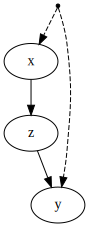

In [2]:
from causalgraphicalmodels import CausalGraphicalModel

system_with_hidden_confounder = CausalGraphicalModel(
    nodes=["x", "y", "z"],
    edges=[("x", "z"), ("z", "y")],
    latent_edges=[("x", "y")]
)

system_with_hidden_confounder.draw()

It's important to realise that this notation is only a convenience: we could simply add another variable as a parent to each pair of confounded variables, and reason about the resulting graph. The reason we include them as hidden variables is that it allows us to automatically reason about whether or not it is possible to infer the results of interventions. 

Consider the graph above. The introduction of the hidden variable means that it is no longer possible to always use the backdoor adjustment to reason about about interventions - there is no valid backdoor adjustment for the graph above because the confounding variable is unobserved:

In [3]:
system_with_hidden_confounder.get_all_backdoor_adjustment_sets("x", "y")

frozenset()

But all is not lost. The fact we observe variable $Z$ allows us to take another approach

# Front Door Adjustment

 Let's begin by writing our target:

$\Pc{Y}{\do{X}}$

We can expand this by including variable $Z$ (as in my previous post, I'm assuming all variables are discrete - if they are continuous, replace the sum with a integral)

$ = \sum_{Z}\Pc{Y}{\do{X}, Z}\Pc{Z}{\do{X}}$

Because there is only one directed path from $X$ to $Z$, their conditional distribution is the same as their interventional distribution and we can replace the $\do{\dots}$ in the second conditional with the observational value:

$ = \sum_{Z}\Pc{Y}{\do{X}, Z}\Pc{Z}{X}$

We can't make a similar adjustment to the first term, because there is a backdoor path between $X$ and $Y$. We can however replace the observed $Z$ with its intervential value $\do{Z}$:

$ = \sum_{Z}\Pc{Y}{\do{X}, \do{Z}}\Pc{Z}{X}$

Doing this, we can remove $\do{X}$ from the first conditional, because when we intervene on $Z$, we "screen off" the intervention on $X$:

$ = \sum_{Z}\Pc{Y}{\do{Z}}\Pc{Z}{X}$

It might not look like we've achieved much yet by replacing one intervention with another, but $\Pc{Y}{\do{Z}}$ is something we know how to manipulate: we can use backdoor adjustment. Conditioning again on $X$ blocks the back door between $Y$ and $Z$, allowing us to write:

$ = \sum_{Z}\Pc{Z}{X}\left(\sum_{X'}\Pc{Y}{Z, X'}\P{X'}\right)$

This is pretty amazing: we've managed to convert a causal statement into one about observations _despite there being unmeasured confounders_. There are still some strong assumptions here - we need to have observed mediation mechanism between $X$ and $Y$ that is somehow free from direct influence of the confounders, but it is not impossible to imagine situations where this might hold. I found it surprising that this kind of manipulation was possible.

We can verify that in the causal graphical model above, $Z$ is a valid variable for front door adjustment using the following code:

In [4]:
# {"z"} is a valid frontdoor adjustment set
system_with_hidden_confounder.is_valid_frontdoor_adjustment_set("x", "y", {"z"})

True

In [5]:
# but the empty set is not
system_with_hidden_confounder.is_valid_frontdoor_adjustment_set("x", "y", {})

False

And we can compute every valid frontdoor adjustment set using the following:

In [6]:
system_with_hidden_confounder.get_all_frontdoor_adjustment_sets("x", "y")

frozenset({frozenset({'z'})})

The set of manipulations I carried out above to derived the frontdoor adjustment are not at all obvious. In deriving them I use a few imprecise arguments. The manipulation I carried out can be made precise, and are known as [do-calculus](http://ftp.cs.ucla.edu/pub/stat_ser/r402.pdf) - but that is a story for another blog post.

# Estimating the ATE using the Front Door Adjustment

In the previous section we derived the relationship 

$\Pc{Y}{\do{X}} = \sum_{Z}\Pc{Z}{X}\left(\sum_{X'}\Pc{Y}{Z, X'}\P{X'}\right)$

for valid frontdoor adjustment sets $Z$. 

The remaining question is: given observational data, how do we calculate it?

To simplify things a bit, I am going to look at the simpler question:

$\Ec{Y}{\do{X}} = \sum_{Z}\Pc{Z}{X}\left(\sum_{X'}\Ec{Y}{Z, X'}\P{X'}\right)$

$ = \sum_{X', Y, Z} Y \, \Pc{Y}{Z, X'} \Pc{Z}{X} \P{X'}$

Which is about the expectation of $Y$, under intervention $X$. 

We can reduce this to a single number, the average treatment effect (ATE):

$ATE = \Ec{Y}{\do{X=1}} - \Ec{Y}{\do{X=0}}$

The most direct way to estimate this is to estimate each separate conditional probability and combine the results.

Let's start by defining a `StructuralCausalModel` we can sample from:

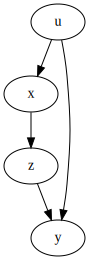

In [7]:
from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

fd0 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "x": discrete_model(["u"], {(0,): (0,1), (1,): (1,0)}),
    "z": discrete_model(["x"], {(0,): (0.95, 0.05), (1,): (0.05, 0.95)}),
    "y": discrete_model(["z", "u"], {
        (0, 0): (0.95, 0.05), 
        (0, 1): (0.95, 0.05),
        (1, 0): (0.50, 0.50), 
        (1, 1): (0.95, 0.05),
    }),
})

fd0.cgm.draw()

This model relates four binary variables: $X$, $Z$, $Y$ and $U$. For the rest of this post I will assume that $U$ is unobserved. If it was we could adjust for it directly. Instead we have to use the frontdoor. 

Before that, we should have some idea what the actual ATE is. The following functions allow us to empirically estimate the ATE from a `StructuralCausalModel`:

In [8]:
def estimate_conditional_expectation(df, x, y):
    """
    Estimate E[Y|X=1] - E[Y|X=0]
    
    from a dataframe `df` of samples.
    
    Arguments
    ---------
    df: pandas.DataFrame
    
    x: str
    
    y: str
    
    Returns
    -------
    estimates: tuple[float, float]
        estiamted difference and standard deviation
    """
    a = df.loc[lambda df: df[x] == 0]
    b = df.loc[lambda df: df[x] == 1]
    
    n_a = a.shape[0]
    n_b = b.shape[0]
    
    delta = b[y].mean() - a[y].mean()
    delta_std = np.sqrt(a[y].var() / n_a + b[y].var() / n_b)
    
    return (delta, delta_std)


def ab_test(scm, x, y, n=10000):
    """
    Simulate an A/B on StructuralCausalModel scm
    to estimate the quantity:
    
    E[Y|do(X) = 1] - E[Y|do(X) = 0]
    
    Arguments
    ---------
    scm: StructuralCausalmodel
    
    x: str
    
    y: str
    
    Returns
    -------
    estimate: tuple[estimates, estiamte_std]
    
    """
    scm_do = scm.do(x)
    
    n_a = int(n / 2)
    n_b = n - n_a
    set_variable = np.array([0]*n_a + [1]*n_b)
    
    samp = (
        scm_do
        .sample(
            set_values={x: set_variable}, 
            n_samples=n)
    )
    
    return estimate_conditional_expectation(samp, x, y)

In [9]:
print("Estimated ATE: {:.3f}".format(ab_test(fd0, "x", "y")[0]))

Estimated ATE: 0.208


We now need a function to make the same calculation using our frontdoor adjustment formula:

In [10]:
def estiamte_ate_frontdoor_direct(df, x, y, zs):
    """
    Estiamte the ATE of a system from a dataframe of samples `ds`
    using frontdoor adjustment directly on ML estimates of probability.
    
    E[Y|do(X) = x'] = \sum_{x,y,z} y P[y|x,z] P(z|x') P(X)
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    zs: list[str]
    
    Returns 
    -------
    ATE: float
    """
    zs_unique = [tuple(a) for a in np.unique(df[zs].values, axis=0)]
    y_unique = np.unique(df[y].values, axis=0)    
    
    # P(X)
    p_x = {
        x_: np.mean(df[x] == x_)
        for x_ in (0,1)
    }
    
    # P(Z|X)
    p_z_x = {
        (x_, z_): np.mean(df
            .loc[lambda df_: df_[x] == x_]
            [zs]
            .values == z_)
        for x_ in (0,1)
        for z_ in zs_unique
    }
    
    # P(Y|X,Z)
    p_y_xz = {
        (x_, y_, z_): np.mean(df
             .loc[lambda df_: df_[x] == x_]
             .loc[lambda df_: (df_[zs].as_matrix() == z_).squeeze()]
             [y]
             .values == y_)
        for x_ in (0,1)
        for y_ in y_unique
        for z_ in zs_unique
    }
    
    
    # ATE
    E_y_do_x_0 = 0.0
    E_y_do_x_1 = 0.0
        
    for y_ in y_unique:
        for zs_ in  zs_unique:
            for x_ in [0,1]:
                E_y_do_x_0 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(0, zs_)] * p_x[x_]
                E_y_do_x_1 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(1, zs_)] * p_x[x_]
    
    return E_y_do_x_1 - E_y_do_x_0

In [11]:
ds = fd0.sample(10000)

estiamte_ate_frontdoor_direct(ds, "x", "y", ["z"])

0.20228124029189454

It works! 

But what happens when we have continuous values? Or sparse discrete values? In these cases directly estimating the conditional probabilities is impractical.

There are a number of approaches you can take - which ones you want to use will depend on exactly which assumptions you are will to make about you data. Let's start by looking at what we can do when assume the data is linear. In doing so we will get a feeling for what the front door adjustment is doing.

# Linear Relationship

The linear approximation assumes that there are linear relationships between $X$, $Z$ and $Y$, or that:

$Z = a_{z} + b_{z, x} X + \epsilon_{z}$

$Y = a_{y} + b_{y, z} Z + b_{y, u} U + \epsilon_{y}$

If these are the _true_ data generating equations then the causal effect of changing $X$ on $Y$ is given by the product of coefficients $ b_{z, x}  b_{y, z}$. Simple regression doesn't allow us to estimate this value because the unmeasured variable $U$ is a parent of both $X$ and $Y$ - and if $X$ and $U$ end up [collinear](https://en.wikipedia.org/wiki/Multicollinearity), our estimate of $b_{y, z}$ cannot be trusted.

One way to side-step this issue is to perform a double regression:

1. First we regress $Z$ on $X$. This not only gives us the coefficient $b_{z, x}$, but the way to estimate $\Ec{Z}{X}$. If this estimate of $\Ec{Z}{X}$ is accurate, we can use it to find the values of the noise in the first equation. Specifically: $ Z - \Ec{Z}{X} = \epsilon_{z}$

2. This noise is only introduced at the node for $Z$, which means that by assumption it is independent of the confounding variable $U$. Regressing $\epsilon_{z}$ on $Y$ then gives us an estimate of the coefficient $b_{y, z}$ where we don't have to worry about the collinearity problem.

Together this procedure gives us the following estimate of 

In [18]:
import statsmodels.api as sm

def estimate_ate_frontdoor_linear(df, x, y, z):
    """
    Estiamte the ATE of a system from a dataframe of samples `df`
    using frontdoor adjustment and assuming linear models.
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    z: str
    
    Returns 
    -------
    ATE: float
    """
    x = df[x].values
    y = df[y].values
    z = df[z].values
    
    z_x_model = sm.OLS(z, sm.add_constant(x)).fit()
    
    z_bar = z_x_model.predict(sm.add_constant(x))
    z_prime = z - z_bar

    y_z_model = sm.OLS(y, sm.add_constant(z_prime)).fit()
    
    return y_z_model.params[1] * z_x_model.params[1]

Let's see how it does:

In [13]:
# first define a linear model
fd1 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "x": discrete_model(["u"], {(0,): (0,1), (1,): (1,0)}),
    "z": linear_model(["x"], [8], -3),
    "y": linear_model(["z", "u"], [1, 8], -2),
})

# sample from the model
n = int(10e4)
ds = fd1.sample(n)

# evaluate the model
print("Different estimates of the ATE for a linear system")
print("--------------------------------------------------")
print("Naive estimator: {:.3f}".format(estimate_conditional_expectation(ds, "x", "y")[0]))
print("AB test: {:.3f}".format(ab_test(fd1, "x", "y", n=n)[0]))
print("Linear estimator: {:.3f}".format(estimate_ate_frontdoor_linear(ds, "x", "y", "z")))

Different estimates of the ATE for a linear system
--------------------------------------------------
Naive estimator: 0.004
AB test: 8.033
Linear estimator: 8.012


It looks reasonably good.

It is worth reflecting on what this process is doing: we are using the randomness introduced by the intermediate variable $Z$ to try and disentangle the confounded relationship between $X$ and $Y$. In some ways this is exactly what the more general frontdoor adjustment is doing: we combine our knowledge of the effect of an intervention at $X$ on $Z$ with the effect of an intervention on $Z$ using $X$ to remove it's bias.

# Beyond linear models 

Linear models are powerful when the data is approximately linear, but often this is too restrictive an assumption. We may also want to introduce categoric variables which may not fit into a linear model framework. 

There are a number of approaches we can take. The one I am going to look at here is the semi-parametric estimator inspired by [this paper](https://arxiv.org/pdf/1210.4654.pdf). It requires us to make some assumptions about how we can model parts of our data, and leaves others to be estimated non-parametrically from the data. It is not only estimator that exists. 

The estimator is:

$\Ec{Y}{\do{X=x}} = \frac{1}{N}\sum_{i} \frac{g(z_{i}) I(x_{i} = x)}{\hat{p}(x_{i})}$

Where 

- $I(x_{i} = x)$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function): one when $x_{i} = x$ and zero otherwise
- $\hat{p}(x_{i})$ is an estimate of the propensity of $x_{i}$ being observed
- $g(z_{i})$ is an estimate of $\Ec{\Ec{y}{x,z}}{z}$
- the sum runs over all the samples

To understand how this estimator works, let's start expanding the probability distribution of our samples using Bayes theorem to get:

$\P{x,y,z} = \Pc{y}{x,z}\Pc{z}{x}\P{x}$

Averaging our estimator over our samples gives us an estimate of 

$\E{\frac{g(z_{i}) I(x_{i} = x')}{\hat{p}(x_{i})}} = \sum_{x,y,z} \Pc{y}{x,z}\Pc{z}{x}\P{x} \frac{g(z) I(x = x')}{\hat{p}(x)}$

If we assume that our model $\hat{p}(x_{i})$ is accurate we can simplify this to 

$\sum_{x,y,z} \Pc{y}{x,z}\Pc{z}{x} g(z) I(x = x')$

The summing over $x$ and keeping only the non-zero values we get

$\sum_{z} \Pc{z}{x'} g(z)$

And replacing $g$ with the thing it is trying to estimate, we get

$\sum_{x,y,z} y \Pc{y}{x,z}\P{x}\Pc{z}{x'}$

Which, if you compare it with the definition of the frontdoor adjustment, is exactly the quantity we were trying to estimate. 

It is important to note that in demonstrating that this estimator matches the frontdoor adjustment we have ignored a number of import questions around asymptotic efficiency of the estimator. This is important and will affect the quality of your results, but they are also a question for another blog post.

We have also not discussed how to calculate $g(z)$ or $\hat{p}(x)$ - this is a much easier problem to address. For binary $x$, $\hat{p}(x)$ can be estimated from the sample averages and $g(z)$ can be calculated using you favorite machine learning technique to estimate a conditional mean (although we must be careful to use stacking when computing the estimate to avoid training on the same data we are predicting on).

Some example code is below

In [14]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold

def stack_predict_and_sum(x, z, y, model, n_splits=3):
    """
    Estimate E[ E[Y|X,Z] |Z]
    
    Assumes that X is a binary value, and uses `model` to
    predict the conditional mean. To prevent overfitting on 
    the data itself, we use stacking to predict on data that 
    wasn't used for fitting.
    
    Arguments
    ---------
    x: numpy.array [Nx1] binary array
    y: numpy.array [Nx1] target array
    z: numpy.array [NxM] feature array
    model: sklearn.estimator
    
    Returns 
    -------
    numpy.array [Nx1]
    """
    kf = KFold(n_splits=n_splits, shuffle=True)
    output = np.zeros_like(y, dtype=np.float)
    p_x = np.mean(x)
    
    for train_index, test_index in kf.split(x):
        x_train = x[train_index]
        x_test  = x[test_index]
        
        z_train = z[train_index]
        z_test  = z[test_index]
        
        y_train = y[train_index]
        y_test  = y[test_index]      
        
        # train model on train set
        X = np.concatenate([x_train, z_train], axis=1)
        model.fit(X, y_train.squeeze())
        
        # predict model on z from test set and x=0, x=1
        X_pred_x_0 = np.concatenate([np.zeros_like(x_test), z_test], axis=1)
        X_pred_x_1 = np.concatenate([np.ones_like(x_test), z_test], axis=1)
        
        y_pred_x_0 = model.predict(X_pred_x_0).reshape(-1,1)
        y_pred_x_1 = model.predict(X_pred_x_1).reshape(-1,1)
        
        output[test_index] = (p_x * y_pred_x_1 + (1-p_x)*y_pred_x_0)
       
    return output


def estimate_intervention_frontdoor_nonlinear(ds, x, y, z, model_y_zx):
    """
    Estiamte the ATE of a system from a dataframe of samples `df`
    using a semi-parametric frontdoor adjustment with a arbritary 
    model of the conditional expectation. 
    
    Stacking is used to prevent overfitting on the data.
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    z: List[str]
    model_y_zx: sklearn.estimator 
    
    Returns 
    -------
    ATE: float
    """
    x = ds[[x]].values
    y = ds[[y]].values
    z = ds[z].values

    mask_x0 = ds.x.values == 0

    # P(x)
    p_x_0 = np.mean(mask_x0)
    p_x_1 = 1 - p_x_0
    p_x = np.where(mask_x0, p_x_0, p_x_1)

    # E[ E[Y|X,Z] |Z]
    y_z_mean = stack_predict_and_sum(x=x, y=y, z=z, model=model_y_zx).squeeze()

    # sum over samples and estimate:
    E_y_do_x0 = np.mean((y_z_mean * mask_x0) / (1 - p_x))
    E_y_do_x1 = np.mean((y_z_mean * (~mask_x0)) / (p_x))
    
    return E_y_do_x1 - E_y_do_x0

Let's see how it performs. 

To evaluate the estimator we are going to use the following non-linear frontdoor-like system.

In [15]:
# Define the model
fd2 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "x": discrete_model(["u"], {(0,): (1.00,0.00), (1,): (0.00, 1.00)}),
    "z": lambda x, n_samples: np.where(
        x == 0,
        np.random.triangular(0,0,1, size=n_samples),
        np.random.triangular(0,1,1, size=n_samples),
    ),
    "y": lambda z, u, n_samples: np.where(
        u == 0, 
        1-(4*(z - 0.5)**2),
        (4*(z - 0.5)**2)
    ),
})

# sample from the model
n = int(10e3)
ds = fd2.sample(n)

# evaluate the model
print("Different estimates of the ATE")
print("------------------------------")
print("Naive estimator: {:.3f}".format(estimate_conditional_expectation(ds, "x", "y")[0]))
print("AB test: {:.3f}".format(ab_test(fd2, "x", "y", n=n)[0]))
print("Linear test: {:.3f}".format(estimate_ate_frontdoor_linear(ds, "x", "y", "z")))
print("Non-linear: {:.3f}".format(
    estimate_intervention_frontdoor_nonlinear(
        ds, "x", "y", ["z"], model_y_zx=RandomForestRegressor())))

Different estimates of the ATE
------------------------------
Naive estimator: -0.338
AB test: -0.001
Linear test: 0.272
Non-linear: -0.012


The actual ATE is zero, which our estimate predicts correctly, but the linear ATE model predict incorrectly.

This looks good - but it important to realise that there are limitations. Let's go back to the second `StructuralCausalModel` we created: the linear system and see how our estimator performs:

In [16]:
# sample from the model
n = int(10e3)
ds = fd1.sample(n)

print("Different estimates of the ATE for a linear system")
print("--------------------------------------------------")
print("Naive estimator: {:.3f}".format(estimate_conditional_expectation(ds, "x", "y")[0]))
print("AB test: {:.3f}".format(ab_test(fd1, "x", "y", n=n)[0]))
print("Linear estimator: {:.3f}".format(estimate_ate_frontdoor_linear(ds, "x", "y", "z")))
print("Non-linear estimator: {:.3f}".format(
    estimate_intervention_frontdoor_nonlinear(
        ds, "x", "y", ["z"], model_y_zx=RandomForestRegressor())))

Different estimates of the ATE for a linear system
--------------------------------------------------
Naive estimator: 0.050
AB test: 8.092
Linear estimator: 8.054
Non-linear estimator: 1.424


It doesn't do well. The reason for this is that we have violated one of the assumptions of the model we're using: good overlap of the covariates. We are using a [random forest](https://en.wikipedia.org/wiki/Random_forest) model to estimate the conditional expectation. This kind of model will do well when we have samples that have good overlap, but fail badly if they attempt to extrapolate beyond that range. 

Conversely, if a system is actually linear, a well fitted linear model will be able to extrapolate well beyond the range it was trained on. This is why the results of the linear ATE are so good in this case. 

If we plot the value of our $Z$ variable for the linear model, the lack of overlap becomes clear:

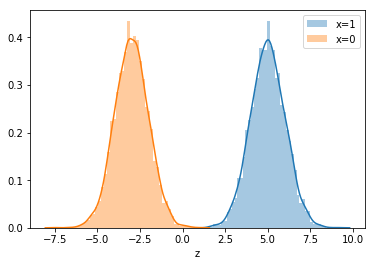

In [17]:
z1 = ds.loc[lambda df: df.x == 1].z
z0 = ds.loc[lambda df: df.x == 0].z

sns.distplot(z1, label="x=1")
sns.distplot(z0, label="x=0")

plt.legend();

It is important to realise that this trade-off between ability-to-extrapolate and quality-of-the-model (note: I am not using these terms in a precise way) is nothing specific to front door adjustment: [we saw exactly the same thing in my first post which focused on techniques that applied backdoor adjustment](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/#Covariate-Imbalance). This is not even specific to causal inference - any model building approach will require some trade-off at this level.

The main difference between using models to make causal inferences and using them for predictions is that if our goal is just predictions we can use [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) to assess the accuracy of our model. When doing causal inference we usually have to rely assumptions about the system - and any conclusions we draw from our models will only be as good as the assumptions we put in. 

# Conclusion

In this post I've covered how we can use the front door adjustment approach to estimate the average treatment effect even in situations where we do not have access to the confounding variables of a system. While this is  powerful, it does require other assumptions about our ability to observe mediating variables. 

At a more general level, I have hoped to demonstrate that there is more to causal inference then just the back door adjustment, and that graphical models are an excellent way to express our knowledge of a system. It should also raise the question: are there more general causal inference approaches than just frontdoor and backdoor adjustment?

In turns out there are. The system of rule for deriving such expressions is known as [do-calculus](http://ftp.cs.ucla.edu/pub/stat_ser/r402.pdf) and I plan to write my next post on this topic. 

A separate but more practical question is once we have these expressions about causal interventions, how do we _actually estimate_ there values? This is a fascinating topic in itself, and one I hope to tackle in another post. 

# Code

You can find the notebook for this post on github [here](https://github.com/ijmbarr/notes-on-causal-inference).